# <font size="7"> Captcha Solver with Deep Learning </font>

The CAPTCHA has become an important issue in multimedia security. CAPTCHAs were designed to prevent computers from automatically filling out forms by verifying that you are a real person. But with the rise of deep learning and computer vision, they can now often be defeated easily. 

<br />
<div>
<img src="notebookImages/ANeuralNetwork.jfif" width="500"/>
</div>
<br />

In this notebook, we implement CAPTCHA image recognition and prediction. We study the use of a Deep Learning algorithm- Convolutional Neural Network in CAPTCHA recognition. We also use simpler classification algorithms- Randomn Forest and K-Nearest Neighbours. The accuracy of each is compared. 

# The Dataset

The dataset consists of 4-letter CAPTCHAs using a random mix of four different fonts. The CAPTCHAs have both alphabets and numbers. Our training data has 10,000 PNG files with the correct answer for each as the filename.
Here is what it looks like-

<br />
<div>
<img src="notebookImages/aLookAtTheDataset.PNG" width="500"/>
</div>
<br />

We know that the CAPTCHA images are always made of 4 alphanumeric characters. We will split the CAPTCHA such that each letter is a separate image. This way, we only have to train the neural network to recognize a single letter at a time. Hence we extract different variations of each letter into another folder. Here's a look at that folder-

<br />
<div>
<img src="notebookImages/Rletter.PNG" width="500"/>
</div>
<br />

# Image Processing

In this segment, we will read in input captcha, do some image procesing to detect 4 regions within the CAPTCHA and save separate images of the characters.

In [1]:
'Importing required packages'

import cv2
import imutils
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import os.path
import glob
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import pickle
import tensorflow
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
import sys

Using TensorFlow backend.


### Class containing Image Processing functions

1. Resize the image - Depending on whichever is greater, height or width, we resize along that side and then we pad the image. Padding is the space between an image or cell contents and its outside border.
2. Image Tresholding - Image thresholding is a simple form of image segmentation. It is a way to create a binary image from a grayscale or full-color image. This is done in order to separate "object" or foreground pixels from background pixels. This makes it easy to find the continous regions. 
3. Finding Regions - We use OpenCV’s findContours() function to detect the separate parts of the image that contain continuous blobs of pixels of the same color.
4. We then save each region as a separate image file maintaing the order.

In [2]:
class captcha_breaker:
    
    def resizeImg(image, width, height):
        (imgH, imgW) = image.shape[:2]
        if imgW > imgH:
            image = imutils.resize(image, width=width)
        else:
            image = imutils.resize(image, height=height) 
        newW = int((width - image.shape[1]) / 2.0)
        newH = int((height - image.shape[0]) / 2.0)
        image = cv2.copyMakeBorder(image, newH, newH, newW, newW,
            cv2.BORDER_REPLICATE)
        image = cv2.resize(image, (width, height))
        return image
    
    
    def processImg(img):    
        imgBorder = cv2.copyMakeBorder(img, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
        ret, imgThreshold = cv2.threshold(imgBorder, 127, 255, cv2.THRESH_BINARY)
        kernel = np.ones((1,2), np.uint8)
        imgErode = cv2.erode(imgThreshold, kernel, iterations = 1)
        return imgErode
    
    
    def getImgRegion(imgErode):
        contours = cv2.findContours(imgErode, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0]
        imageRegions = []
        areaArr = []

        for contour in contours:
            area = cv2.contourArea(contour)
            areaArr.append(area)
        median = 0
        areaArr.sort()
        if len(areaArr)%2 != 0:
            mid = int(len(areaArr)/2)
            median = areaArr[mid]
        else:
            mid = int(len(areaArr)/2)
            median = (areaArr[mid] + areaArr[mid - 1])/2

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 3*median or area < median/3:
                continue;

            x, y, w, h = cv2.boundingRect(contour)
            imgRGB = cv2.cvtColor(imgErode,cv2.COLOR_GRAY2RGB)
            if w/h > 1.25:
                half_width = int(w/2)
                imageRegions.append((x, y, half_width, h))
                imageRegions.append((x + half_width, y, half_width, h))
            else:
                imageRegions.append((x, y, w, h))

        imageRegions = sorted(imageRegions, key=lambda x: x[0])
        return imageRegions
    
    def printRegions(imageRegions):
        for point in imageRegions:    
            imgRGB = cv2.cvtColor(imgErode, cv2.COLOR_GRAY2RGB)
            imgRect = cv2.rectangle(imgRGB, (point[0], point[1]), (point[0]+point[2], point[1]+point[3]), (255,0,0), 1)

            plt.imshow(imgRect)
            plt.axis('off')
            plt.show()
            
    

Now we're ready to try it on some data.
This is going to be done in three parts:
I. Processing the CAPTCHA
II. CAPTCHA prediction using Neural Network
III. Randomn Forest and 

# I. Processing the CAPTCHA

### Image Tresholding - To increase the quality of image

In [3]:
'Input a test CAPTCHA. Perform Image Tresholding'

cb = captcha_breaker
img = cv2.imread("tests/01.png", 0)
imgErode = cb.processImg(img)


### Finding Regions - To find separate parts of the image that contain continuous blobs of pixels of the same color

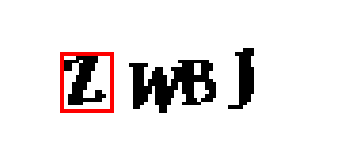

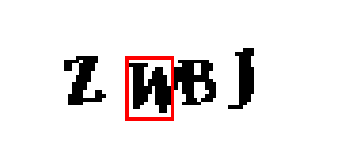

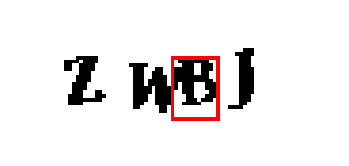

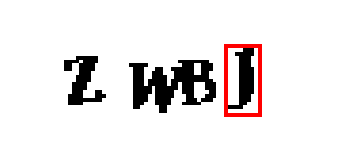

In [4]:
imageRegions = cb.getImgRegion(imgErode)
cb.printRegions(imageRegions)

### Processing the data - Find and save as separate alphanumeric value 

### Extracting single letter images and saving it in a folder called data_letters

In [9]:
FOLDER_INPUT = "CAPTCHA_IMGS"
FOLDER_OUTPUT = "Single_letters"
captchaImgs = glob.glob(os.path.join(FOLDER_INPUT, "*"))
countLetter = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
countNumber = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i, file in enumerate(captchaImgs):
    name = os.path.basename(file)
    captchaText = os.path.splitext(name)[0]
    pathImg = "CAPTCHA_IMGS/" + name  
    img = cv2.imread(pathImg, 0)   
    imgErode = cb.processImg(img)
    
    imageRegions = cb.getImgRegion(imgErode)
    if len(imageRegions) != 4:
        continue;
        
    for points, letter in zip(imageRegions, captchaText):
        x, y, w, h = points
        
        imageSave = imgErode[y:y + h, x:x + w]

        pathSave = os.path.join(FOLDER_OUTPUT, letter)
    
        if not os.path.exists(pathSave):
            os.makedirs(pathSave)
        
        ans = ord(letter)

        if ans >= 0 and ans < ord('A'):
            idx = ans - ord('0')
            countNumber[idx] = countNumber[idx] + 1
            strImgPath = str(countNumber[idx]) + ".png"
        else:
            idx = ans - ord('A')
            countLetter[idx] = countLetter[idx] + 1
            strImgPath = str(countLetter[idx]) + ".png"
        
        pt = os.path.join(pathSave, strImgPath)
        cv2.imwrite(pt, imageSave)

print("finish processing")

finish processing


# II. CAPTCHA prediction with Neural Network

## Training the model

In [10]:
FOLDER_LETTERS_INPUT = "Single_letters"

dataImages = []
dataLabels = []

for file in paths.list_images(FOLDER_LETTERS_INPUT):
    image = cv2.imread(file, 0)
    image = cb.resizeImg(image, 20, 20)
    image = np.expand_dims(image, axis=2)

    label = file.split(os.path.sep)[-2]
    
    dataImages.append(image)
    dataLabels.append(label)

print("finish append")


finish append


In [11]:
print(dataLabels[0])

R


In [12]:
print(len(dataImages))
print(len(dataLabels))

34832
34832


In [13]:
FILE_LABELS_MODEL = "label_model.dat"

dataImages = np.array(dataImages)/255
dataLabels = np.array(dataLabels)

encoder = LabelBinarizer()
dataLabels = encoder.fit_transform(dataLabels)

(Xtrain, Xtest, Ytrain, Ytest) = train_test_split(dataImages, dataLabels, test_size=0.25, random_state=70)

with open(FILE_LABELS_MODEL, "wb") as f:
    pickle.dump(encoder, f)


## Building CNN model

In [14]:
MODEL_FILE = "model.hdf5"

main_model = Sequential()

main_model.add(Conv2D(20, (2, 2), padding="same", input_shape=(20, 20, 1), activation="relu"))
main_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

main_model.add(Conv2D(64, (2, 2), padding="same", activation="relu"))
main_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

main_model.add(Flatten())
main_model.add(Dense(500, activation="relu"))

main_model.add(Dense(32, activation="softmax"))

main_model.compile(loss="categorical_crossentropy", optimizer="adagrad", metrics=["accuracy"])



In [15]:
main_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 20)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        5184      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               800500    
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

In [16]:
main_model.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest), batch_size=32, epochs=10, verbose=1)


Train on 26124 samples, validate on 8708 samples
Epoch 1/10
26124/26124 [==============================] - 11s 430us/step - loss: 0.2196 - accuracy: 0.9492 - val_loss: 0.0570 - val_accuracy: 0.9905
Epoch 2/10
26124/26124 [==============================] - 11s 422us/step - loss: 0.0441 - accuracy: 0.9928 - val_loss: 0.0423 - val_accuracy: 0.9918
Epoch 3/10
26124/26124 [==============================] - 11s 406us/step - loss: 0.0313 - accuracy: 0.9945 - val_loss: 0.0356 - val_accuracy: 0.9930
Epoch 4/10
26124/26124 [==============================] - 11s 430us/step - loss: 0.0236 - accuracy: 0.9957 - val_loss: 0.0336 - val_accuracy: 0.9929
Epoch 5/10
26124/26124 [==============================] - 11s 421us/step - loss: 0.0188 - accuracy: 0.9966 - val_loss: 0.0322 - val_accuracy: 0.9935
Epoch 6/10
26124/26124 [==============================] - 10s 395us/step - loss: 0.0153 - accuracy: 0.9972 - val_loss: 0.0310 - val_accuracy: 0.9941
Epoch 7/10
26124/26124 [==============================] -

In [17]:
main_model.save(MODEL_FILE)

### Prediction class (for CNN, Random forest, KNN)

In [14]:
class captcha_predict:
    def CNNpredictImage(img):
        dataImagesPredict = []

        imgErode = cb.processImg(img)
        imageRegions = cb.getImgRegion(imgErode)

        for points in imageRegions:
            x, y, w, h = points

            image = imgErode[y:y + h, x:x + w]

            image = cb.resizeImg(image, 20, 20)
            image = np.expand_dims(image, axis=2)

            dataImagesPredict.append(image)

        dataImagesPredict = np.array(dataImagesPredict)/255

        for element in dataImagesPredict:
            prediction = main_model.predict(dataImagesPredict)
            letter = encoder.inverse_transform(prediction)
            
        print("CAPTCHA TEXT:", letter)
        plt.imshow(imgErode, cmap='gray')
        plt.axis('off')
        plt.show()
        
    def rfPredict(img):
        dataImagesPredict = []

        imgErode = cb.processImg(img)
        imageRegions = cb.getImgRegion(imgErode)

        for points in imageRegions:
            x, y, w, h = points

            image = imgErode[y:y + h, x:x + w]

            image = cb.resizeImg(image, 20, 20)
            image = np.expand_dims(image, axis=2)

            dataImagesPredict.append(image)

        dataImagesPredict = np.array(dataImagesPredict)/255
        print(dataImagesPredict.shape)
        
        a, b, c, d = dataImagesPredict.shape
        dataImagesPredict = dataImagesPredict.reshape((a,b*c*d))

        for element in dataImagesPredict:
            prediction = rf.predict(dataImagesPredict)
            letter = encoder.inverse_transform(prediction)
            
        print("CAPTCHA TEXT:", letter)
        plt.imshow(imgErode, cmap='gray')
        plt.axis('off')
        plt.show()
        
    def knnPredict(img):
        dataImagesPredict = []

        imgErode = cb.processImg(img)
        imageRegions = cb.getImgRegion(imgErode)

        for points in imageRegions:
            x, y, w, h = points

            image = imgErode[y:y + h, x:x + w]

            image = cb.resizeImg(image, 20, 20)
            image = np.expand_dims(image, axis=2)

            dataImagesPredict.append(image)

        dataImagesPredict = np.array(dataImagesPredict)/255
        print(dataImagesPredict.shape)
        
        a, b, c, d = dataImagesPredict.shape
        dataImagesPredict = dataImagesPredict.reshape((a,b*c*d))

        for element in dataImagesPredict:
            prediction = knn.predict(dataImagesPredict)
            letter = encoder.inverse_transform(prediction)
            
        print("CAPTCHA TEXT:", letter)
        plt.imshow(imgErode, cmap='gray')
        plt.axis('off')
        plt.show()

## CAPTCHA Prediction with CNN

CAPTCHA TEXT: ['Z' 'W' 'B' 'J']


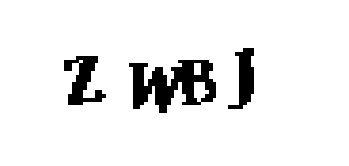

CAPTCHA TEXT: ['C' 'G' 'L' 'T']


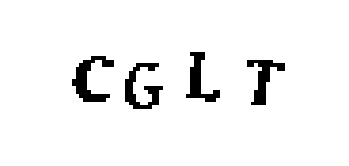

In [16]:
cp = captcha_predict

img = cv2.imread("tests/01.png", 0)
cp.CNNpredictImage(img)

img = cv2.imread("tests/02.png", 0)
cp.CNNpredictImage(img)

We have tested our model with 2 test cases. In both cases, the CAPTCHA text and the image matches.

We will now use Rondom Forest and KNN algorithms and see how they fare compared to CNN.

# III. Randomn Forest and KNN Classification Algorithms

### Data Modeling

In [17]:
Xtrain.shape
a, b, c, d = Xtrain.shape
XtrainNew = Xtrain.reshape((a,b*c))
XtrainNew.shape

(26124, 400)

In [18]:
Xtest.shape
a, b, c, d = Xtest.shape
XtestNew = Xtest.reshape((a,b*c*d))
XtestNew.shape

(8708, 400)

In [19]:
Ytrain.shape

(26124, 32)

# Randomn Forest

### Training Random Forest Model

In [20]:
def model_training(model, X, y):
  model.fit(X,y)
  
  return(model)

In [21]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

rf = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_features='sqrt',
                            n_jobs=-1)
model_training(rf, XtrainNew, Ytrain)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

### Accuracy for random forest

In [22]:
def get_acuuracy(model, X, y):
  y_pred = model.predict(X)

  if sys.version_info < (3, 0):
      accuracy = ((np.sum(y == y_pred, axis=0)).astype('float') /
            X.shape[0])
  else:
      accuracy = np.sum(y == y_pred, axis=0) / X.shape[0]

  #print('Accuracy: %.2f%%' % (accuracy * 100))
  
  return(accuracy * 100).mean()


training_accuracy=get_acuuracy(rf, XtrainNew, Ytrain)
print('Training accuracy: %.2f%%' %training_accuracy)

test_accuracy=get_acuuracy(rf, XtestNew, Ytest)
print('Test accuracy: %.2f%%' %test_accuracy)

Training accuracy: 100.00%
Test accuracy: 99.94%


### CAPTCHA prediction with Random forest

(4, 20, 20, 1)
CAPTCHA TEXT: ['C' 'G' 'L' 'T']


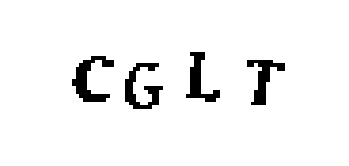

In [23]:
cp = captcha_predict

img = cv2.imread("tests/02.png", 0)
cp.rfPredict(img)

# K-Nearest Neighbours

In [24]:
from sklearn.neighbors import KNeighborsClassifier

#import metrics model to check the accuracy 
from sklearn import metrics
#Running from k=1 through 5 and record testing accuracy
k_range = range(1,5)
scores = {}
scores_list = []
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(XtrainNew,Ytrain)
        y_pred=knn.predict(XtestNew)
        scores[k] = metrics.accuracy_score(Ytest,y_pred)
        scores_list.append(metrics.accuracy_score(Ytest,y_pred))
        
        

In [25]:
scores

{1: 0.9916169039963252,
 2: 0.9873679375287092,
 3: 0.9901240238860818,
 4: 0.987827285254938}

Text(0, 0.5, 'Testing Accuracy')

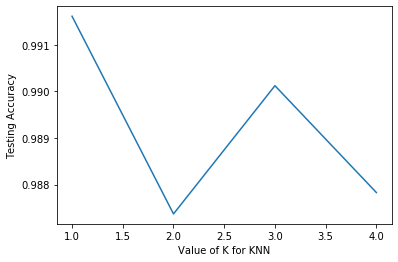

In [26]:
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

### Training our KNN model

Since we know that there are 4 clusters, we will choose k=4. 

In [27]:
'Setup a knn classifier with k neighbors'

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(XtrainNew,Ytrain)

#Fitting the model
knn.fit(XtrainNew,Ytrain)
y_pred = knn.predict(XtestNew)

### Obtaining Accuracy of our KNN model

In [28]:
from sklearn.metrics import classification_report

Accuracy=knn.score(XtestNew,Ytest)
print('KNN Accuracy:',Accuracy)
print(classification_report(Ytest, y_pred))

KNN Accuracy: 0.987827285254938
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       266
           1       1.00      0.99      0.99       269
           2       1.00      0.98      0.99       263
           3       0.99      0.97      0.98       278
           4       1.00      0.99      1.00       279
           5       0.99      0.98      0.99       293
           6       0.99      0.99      0.99       256
           7       1.00      1.00      1.00       327
           8       1.00      1.00      1.00       267
           9       1.00      0.97      0.99       233
          10       1.00      0.99      0.99       251
          11       1.00      0.99      0.99       265
          12       1.00      0.97      0.99       283
          13       0.99      1.00      0.99       271
          14       1.00      0.99      0.99       268
          15       1.00      1.00      1.00       301
          16       0.99      0.99      0.99      

/Users/lakshmi/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


### CAPTCHA prediction with KNN 

(4, 20, 20, 1)
CAPTCHA TEXT: ['C' 'G' 'L' 'T']


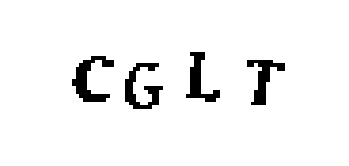

In [29]:
cp = captcha_predict

img = cv2.imread("tests/02.png", 0)
cp.knnPredict(img)

The accuracy of KNN is satisfactory and the prediction is accurate. 

# <font size="7"> Conclusion

We are successful in implementing CAPTCHA recognition and prediction using Neural Networks on our dataset. We also trained and tested Random Forest and KNN classification algorithms. Both models had good accuracy of over 98%. Even though the accuracy was satisfactory in this case, both these algorithms become significantly slower as the volume of data increases making them an impractical choice in environments where predictions need to be made rapidly. Hence CNN emerges as the algorithm of choice.